# Toy Problem Optimization

This notebook explores what happens when you take the two-link rope toy problem and pull the rope only towards increase X, which is easy

In [1]:
import notebook_finder
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=2)
import toy_problem_optimization_common as tpo
from toy_problem_optimization_common import BOLD
np.random.seed(0)

importing Jupyter notebook from toy_problem_optimization_common.ipynb


### Define goal

Our goal will be denoted as $g$, for now we simply assume its defined in the full state space

In [2]:
g = np.array([[5], [0], [6], [0]])

# Manual Data

Let's pretend our data comes from pulling a 2-link object to the right for 6 time steps

In [3]:
manual_data = []
manual_dt = 0.1
for x1 in np.arange(0, 5, manual_dt):
    y = 0 #np.random.randint(-10,10)
    # Training data looks like [(s_t, u_t, s_{t+1}, c_t, c_{t+1})]
    manual_data.append((np.array([[x1],[y],[x1+1],[y]]),
         np.array([[1],[0]]),
         np.array([[x1+manual_dt],[y],[x1+1+manual_dt],[y]]),
         np.array([[(g[0] - x1)**2]]),
         np.array([[(g[0] - (x1+manual_dt))**2]])))

### X Model (Perfect)

This model reduces the full state to just $x_1$. The dynamics are $\dot{o}=v_x$, and the cost is simply the squared difference $(g - x_1)^2$

In [4]:
x_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
x_model.from_params([1, 0, 0, 0, 0, 1, 0, 1])
BOLD("X Model Loss:")
x_eval = tpo.eval_model(x_model, manual_data, g, manual_dt, print_model=False)

**X Model Loss:**

Loss Components:
	current cost: 0.0
	predict next latent state: 0.0
	predict next cost: 0.0
	regularization: 1.7320508075688774e-05
Complete Losses:
	predict next latent state and current cost: 1.7320508075688774e-05
	predict next cost and current cost: 1.7320508075688774e-05


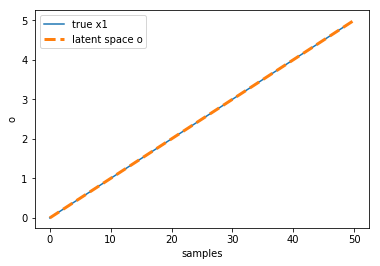

Predicted cost of rollout [[429.25]]


In [5]:
s0 = np.array([[0], [0], [1], [0]])
x_model_rollout_predicted_cost = tpo.plot_rollout(x_model, manual_data, manual_dt, s0, g)
print("Predicted cost of rollout", x_model_rollout_predicted_cost)

### Model with all zeros

We expect this to be bad

In [6]:
zero_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
zero_model.from_params(np.zeros(8))
BOLD("Zero Model Loss:")
zero_eval = tpo.eval_model(zero_model, manual_data, g, manual_dt, print_model=False)

**Zero Model Loss:**

Loss Components:
	current cost: 131.33333
	predict next latent state: 0.0
	predict next cost: 118.83333
	regularization: 0.0
Complete Losses:
	predict next latent state and current cost: 65.666665
	predict next cost and current cost: 125.08332999999999


### Y Model

reduces to just $y_1$, and says $\dot{o}=v_y$, and cost is $(g-y_1)^2$

we expect this to be bad.

In [7]:
y_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
y_model.from_params([0, 1, 0, 0, 0, 0, 1, 1])
BOLD("Y Model Loss:")
y_eval = tpo.eval_model(y_model, manual_data, g, manual_dt, print_model=False)


**Y Model Loss:**

Loss Components:
	current cost: 131.33333
	predict next latent state: 0.0
	predict next cost: 118.83333
	regularization: 1.7320508075688774e-05
Complete Losses:
	predict next latent state and current cost: 65.66668232050807
	predict next cost and current cost: 125.08334732050807


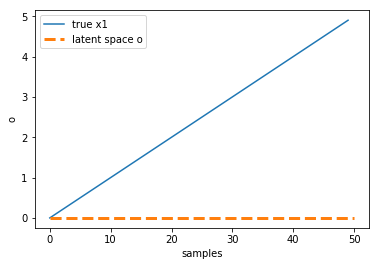

Predicted cost of rollout [[0.]]


In [30]:
s0 = np.array([[0], [0], [1], [0]])
y_model_rollout_predicted_cost = tpo.plot_rollout(y_model, manual_data, manual_dt, s0, g)
print("Predicted cost of rollout", y_model_rollout_predicted_cost)

### Random Models (average)

In [10]:
N = 1000
costs = np.zeros(N)
model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
for i in range(N):
    random_params = np.random.randn(8)
    model.from_params(random_params)
    costs[i] = tpo.state_prediction_objective(model, g, manual_data, manual_dt)
print("Median cost for random parameters {:.3f}".format(np.median(costs)))

Median cost for random parameters 75.125


### Trained  Model (CSP Loss)

In [11]:
csp_manual_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
BOLD("CSP Manual Model Loss:")
csp_manual_eval = tpo.train_and_eval(csp_manual_model, manual_data, g, manual_dt, tpo.state_prediction_objective)

**CSP Manual Model Loss:**

Finished in 5 iterations
Loss Components:
	current cost: 3.1102290258988796e-12
	predict next latent state: 3.1297410425590285e-06
	predict next cost: 0.00010911885892767677
	regularization: 1.712234248638427e-05
Complete Losses:
	predict next latent state and current cost: 1.8687214562778297e-05
	predict next cost and current cost: 7.168177350533717e-05
Model reduction Matrix: [[ 0.38 -0.    0.92 -0.  ]]
Dynamics Matrices: [[0.01]] , [[ 1.26 -0.  ]]
Cost Matrix: [[0.59]]


### Apply learned model given the actions we trained on, starting at the same initial state

Consider what happens if we follow a plan of pulling in positive X from the origin?
The true cost is the sum: $(5-0)^2+(5-0.1)^2+\dots+(5-4.9)^2+(5-5)^2$

In [12]:
# This is what we know the cost will be...
cost = 0
for x1 in np.arange(0, 5, .1):
    cost += (5-x1)**2
print(cost)

429.25000000000006


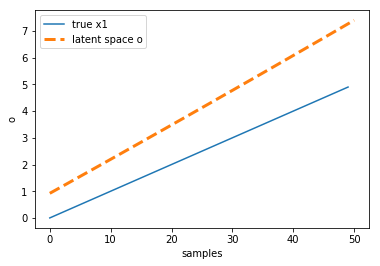

Predicted cost of rollout [[436.19]]


In [31]:
s0 = np.array([[0], [0], [1], [0]])
csp_manual_model_rollout_predicted_cost = tpo.plot_rollout(csp_manual_model, manual_data, manual_dt, s0, g)
print("Predicted cost of rollout", csp_manual_model_rollout_predicted_cost)

### Trained  Model (CCP Loss)

In [15]:
ccp_manual_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
BOLD("CCP Manual Model Loss:")
ccp_manual_eval = tpo.train_and_eval(ccp_manual_model, manual_data, g, manual_dt, tpo.one_step_cost_prediction_objective)

**CCP Manual Model Loss:**

Finished in 5 iterations
Loss Components:
	current cost: 1.1873994757008369e-08
	predict next latent state: 9.41622685976287e-10
	predict next cost: 1.5685117793374934e-08
	regularization: 1.9377948180573744e-05
Complete Losses:
	predict next latent state and current cost: 1.9384355989295235e-05
	predict next cost and current cost: 1.9391727736848936e-05
Model reduction Matrix: [[-1.3   0.    0.29 -0.  ]]
Dynamics Matrices: [[0.]] , [[-1. -0.]]
Cost Matrix: [[0.99]]


### Apply learned model given the actions we trained on, starting at the same initial state

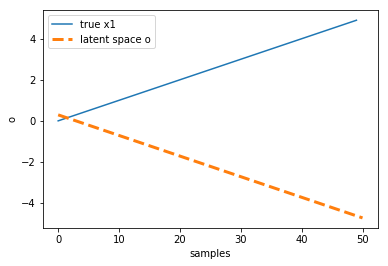

Predicted cost of rollout [[429.39]]


In [32]:
s0 = np.array([[0], [0], [1], [0]])
ccp_manual_model_rollout_predicted_cost = tpo.plot_rollout(ccp_manual_model, manual_data, manual_dt, s0, g)
print("Predicted cost of rollout", ccp_manual_model_rollout_predicted_cost)

# Now with some data from Gazebo

In [33]:
gazebo_fwd_data = tpo.load_gazebo_data("/home/pmitrano/catkin_ws/src/link_bot/link_bot_teleop/data/fwd_1.txt", g)
gazebo_dt = 0.1

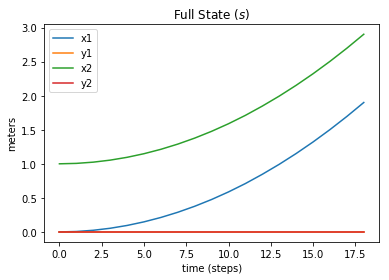

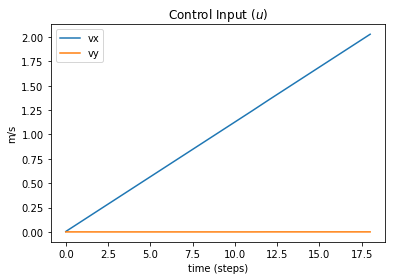

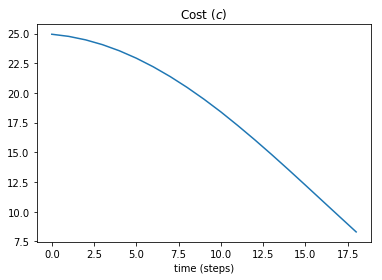

In [34]:
tpo.plot_gz_data(gazebo_fwd_data)

### See how our previous model reduction transfers

To use the same models, the dimensionality of the input data must be the same.

In [35]:
print("Use the models trained on manual synthetic data, test on new Gazebo pull data")
BOLD("CSP Model")
csp_manual_eval_on_gz = tpo.eval_model(csp_manual_model, gazebo_fwd_data, g, gazebo_dt, print_model=False)
BOLD("CCP Model")
ccp_manual_eval_on_gz = tpo.eval_model(ccp_manual_model, gazebo_fwd_data, g, gazebo_dt, print_model=False)

Use the models trained on manual synthetic data, test on new Gazebo pull data


**CSP Model**

Loss Components:
	current cost: 4.1344966550408804e-05
	predict next latent state: 0.00028134324010335444
	predict next cost: 0.00873852582198646
	regularization: 1.712234248638427e-05
Complete Losses:
	predict next latent state and current cost: 0.0001784664458132659
	predict next cost and current cost: 0.004407057736754819


**CCP Model**

Loss Components:
	current cost: 6.2655226905254445e-06
	predict next latent state: 0.0001071056877465219
	predict next cost: 0.007081943094179883
	regularization: 1.9377948180573744e-05
Complete Losses:
	predict next latent state and current cost: 7.606355339909741e-05
	predict next cost and current cost: 0.003563482256615778


### Apply model trained on manual data to gazebo actions

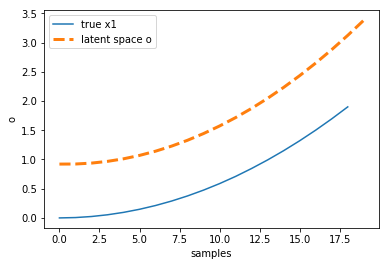

Predicted cost using CSP Manual Model of rollout in Gazebo [[379.06]]


In [37]:
s0 = np.array([[0], [0], [1], [0]])
csp_manual_model_gz_rollout_predicted_cost = tpo.plot_rollout(csp_manual_model, gazebo_fwd_data, gazebo_dt, s0, g)
print("Predicted cost using CSP Manual Model of rollout in Gazebo", csp_manual_model_gz_rollout_predicted_cost)

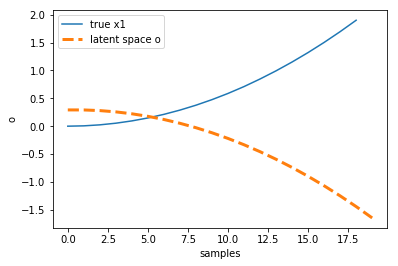

Predicted cost using CCP Manual Model of rollout in Gazebo [[377.43]]


In [38]:
s0 = np.array([[0], [0], [1], [0]])
ccp_manual_model_gz_rollout_predicted_cost = tpo.plot_rollout(ccp_manual_model, gazebo_fwd_data, gazebo_dt, s0, g)
print("Predicted cost using CCP Manual Model of rollout in Gazebo", ccp_manual_model_gz_rollout_predicted_cost)

### Show that our hand-designed parameters still work well

In [25]:
x_model_eval_on_gz = tpo.eval_model(x_model, gazebo_fwd_data, g, gazebo_dt, print_model=False)

Loss Components:
	current cost: 1.2323349190291226e-21
	predict next latent state: 0.00010589009081271507
	predict next cost: 0.006650774857046005
	regularization: 1.7320508075688774e-05
Complete Losses:
	predict next latent state and current cost: 7.02655534820463e-05
	predict next cost and current cost: 0.0033427079365986913


### Try to optimize on our new data

In [26]:
csp_gz_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
csp_gz_eval = tpo.train_and_eval(csp_gz_model, gazebo_fwd_data, g, gazebo_dt, tpo.state_prediction_objective)

Finished in 6 iterations
Loss Components:
	current cost: 1.321148313738186e-06
	predict next latent state: 1.5073623336108046e-05
	predict next cost: 0.0012780091736789851
	regularization: 1.6366682184275227e-05
Complete Losses:
	predict next latent state and current cost: 2.4564068009198344e-05
	predict next cost and current cost: 0.0006560318431806368
Model reduction Matrix: [[-0.79  0.   -0.19  0.  ]]
Dynamics Matrices: [[0.11]] , [[-0.97  0.  ]]
Cost Matrix: [[1.03]]


In [27]:
actions = [d[1] for d in gazebo_fwd_data]
s0 = np.array([[0], [0], [1], [0]])
o = csp_gz_model.reduce(s0)
predicted_total_cost = 0.0
o_s = []
for u in actions:
    c_hat = csp_gz_model.cost_of_o(o, g)
    o = csp_gz_model.predict_from_o(o, u, manual_dt)
    o_s.append(o)
    predicted_total_cost += c_hat
print(predicted_total_cost)

[[371.95]]


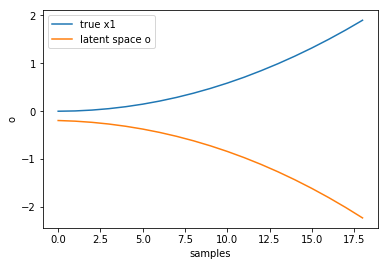

In [28]:
states = [d[0] for d in gazebo_fwd_data]
plt.plot([s[0,0] for s in states], label='true x1')
plt.plot(np.squeeze(o_s), label='latent space o')
plt.xlabel("samples")
plt.ylabel("o")
plt.legend();

In [29]:
ccp_gz_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
ccp_gz_eval = tpo.train_and_eval(ccp_gz_model, gazebo_fwd_data, g, gazebo_dt, tpo.one_step_cost_prediction_objective)

Finished in 16 iterations
Loss Components:
	current cost: 0.029633998924533767
	predict next latent state: 0.031341211026661264
	predict next cost: 3.7385176999658443
	regularization: 0.026777541150118957
Complete Losses:
	predict next latent state and current cost: 0.05726514612571647
	predict next cost and current cost: 1.910853390595308
Model reduction Matrix: [[   -1.28 -1050.67     1.3   -624.14]]
Dynamics Matrices: [[1.58]] , [[  -0.34 -449.77]]
Cost Matrix: [[2339.79]]


# Summary of Results On The Gazebo Pull Data

How well do each of the models do on the Gazebo pull data?

### Trained on CSP 

|Model|Current Cost Loss|Predict State Loss|Predict Cost Loss|Regularization Loss|
|-|-|-|-|-|
|bad model|0|0|0|0|
|x model|0|0|0|0|
|learned model|0|0|0|0|

### Trained on CCP 

|Model|Current Cost Loss|Predict State Loss|Predict Cost Loss|Regularization Loss|
|-|-|-|-|-|
|bad model|0|0|0|0|
|x model|0|0|0|0|
|learned model|0|0|0|0|